# Deep Kernel Learning (DenseNet + GP) on CIFAR10/100

In this notebook, we'll demonstrate the steps necessary to train a medium sized DenseNet (https://arxiv.org/abs/1608.06993) on either of two popularly used benchmark dataset in computer vision (CIFAR10 and CIFAR100). We'll be training the DKL model entirely end to end using the standard 300 Epoch training schedule and SGD.

This notebook is largely for tutorial purposes. If your goal is just to get (for example) a trained DKL + CIFAR100 model, we __recommend__ that you move this code to a simple python script and run that, rather than training directly out of a python notebook. We find that training is just a bit faster out of a python notebook. We also of course recommend that you increase the size of the DenseNet used to a full sized model if you would like to achieve state of the art performance.

Furthermore, because this notebook involves training an actually reasonably large neural network, it is __strongly recommended__ that you have a decent GPU available for this, as with all large deep learning models.

In [3]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import gpytorch
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt


## Set up data augmentation

The first thing we'll do is set up some data augmentation transformations to use during training, as well as some basic normalization to use during both training and testing. We'll use random crops and flips to train the model, and do basic normalization at both training time and test time. To accomplish these transformations, we use standard `torchvision` transforms.

In [4]:
normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
aug_trans = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
common_trans = [transforms.ToTensor4312(), normalize]
train_compose = transforms.Compose(aug_trans + common_trans)
test_compose = transforms.Compose(common_trans)

## Create DataLoaders

Next, we create dataloaders for the selected dataset using the built in torchvision datasets. The cell below will download either the cifar10 or cifar100 dataset, depending on which choice is made. The default here is cifar10, however training is just as fast on either dataset.

After downloading the datasets, we create standard `torch.utils.data.DataLoader`s for each dataset that we will be using to get minibatches of augmented data.

In [5]:
dataset = 'cifar10'

if dataset == 'cifar10':
    d_func = dset.CIFAR10
    train_set = dset.CIFAR10('data', train=True, transform=train_compose, download=True)
    test_set = dset.CIFAR10('data', train=False, transform=test_compose)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
    num_classes = 10
elif dataset == 'cifar100':
    d_func = dset.CIFAR100
    train_set = dset.CIFAR100('data', train=True, transform=train_compose, download=True)
    test_set = dset.CIFAR100('data', train=False, transform=test_compose)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
    num_classes = 100
else:
    raise RuntimeError('dataset must be one of "cifar100" or "cifar10"')

Files already downloaded and verified


## Creating the DenseNet Model

With the data loaded, we can move on to defining our DKL model. A DKL model consists of three components: the neural network, the Gaussian process layer used after the neural network, and the Softmax likelihood.

The first step is defining the neural network architecture. To do this, we use a slightly modified version of the DenseNet available in the standard PyTorch package. Specifically, we modify it to remove the softmax layer, since we'll only be needing the final features extracted from the neural network.

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*6*6, 132)
        self.classifier = nn.Linear(132, 10)
 
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool( x)
        x = self.conv2(x)
        x = F.relu(x)  
        x = self.pool(x)
        x = x.view(-1, 16 * 6 * 6)
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.classifier(x)
        return x
        


In [7]:
def train(model):
    trainloader = train_loader
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(20):
        model.train()
        print('Training...')
        print('Epoch: ', epoch)
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if i % 4000 == 0:
                print('Loss: ', loss.item())
        test(model)

def test(model):
    correct = 0
    total = 0
    testloader = test_loader
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()


    print('Accuracy on all 10000 test images: %d %%' % (100 * correct/total))


In [8]:
from densenet import DenseNet

class DenseNetFeatureExtractor(DenseNet):
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=self.avgpool_size).view(features.size(0), -1)
        return out

# feature_extractor = DenseNetFeatureExtractor(block_config=(6, 6, 6), num_classes=num_classes).cuda()

feature_extractor = SimpleNet()
num_features = feature_extractor.classifier.in_features


## Creating the GP Layer

In the next cell, we create the layer of Gaussian process models that are called after the neural network. In this case, we'll be using one GP per feature, as in the SV-DKL paper. The outputs of these Gaussian processes will the be mixed in the softmax likelihood.

In [9]:
class GaussianProcessLayer(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        super(GaussianProcessLayer, self).__init__(grid_size=grid_size, grid_bounds=[grid_bounds],
                                                   num_dim=num_dim, mixing_params=False, sum_output=False)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

## Creating the DKL Model

With both the DenseNet feature extractor and GP layer defined, we can put them together in a single module that simply calls one and then the other, much like building any Sequential neural network in PyTorch. This completes defining our DKL model.

In [114]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

    def forward(self, x):
        features = self.feature_extractor(x)
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        res = self.gp_layer(features)
        return res

class DKLModelExtended(gpytorch.Module):
    def __init__(self, feature_extractors, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModelExtended, self).__init__()
        self.feature_extractors = feature_extractors
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

    def forward(self, x):
        features = torch.cat([f(x) for f in self.feature_extractors], dim=1)
        # print(f'size of concatenation: {features.size()}')
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        res = self.gp_layer(features)
        return res

# old single feature extractor
# model = DKLModel(feature_extractor, num_dim=num_features).cuda()
# likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, n_classes=num_classes).cuda()

# new multiple feature extractor
num_extractors = 1
feature_extractors = [SimpleNet().cuda() for i in range(num_extractors)]
num_features = sum([x.classifier.in_features for x in feature_extractors])
model = DKLModelExtended(feature_extractors, num_dim=num_features).cuda()
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, n_classes=num_classes).cuda()

## Defining Training and Testing Code

Next, we define the basic optimization loop and testing code. This code is entirely analogous to the standard PyTorch training loop. We create a `torch.optim.SGD` optimizer with the parameters of the neural network on which we apply the standard amount of weight decay suggested from the paper, the parameters of the Gaussian process (from which we omit weight decay, as L2 regualrization on top of variational inference is not necessary), and the mixing parameters of the Softmax likelihood. 

We use the standard learning rate schedule from the paper, where we decrease the learning rate by a factor of ten 50% of the way through training, and again at 75% of the way through training.

In [115]:
n_epochs = 300
lr = 0.1
optimizer = SGD([
    {'params': model.feature_extractors[0].parameters()},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
], lr=lr, momentum=0.9, nesterov=True, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)

optimizer_dkrp = SGD([
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
], lr=lr, momentum=0.9, nesterov=True, weight_decay=0)
scheduler_dkrp = MultiStepLR(optimizer_dkrp, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)

def train(epoch):
    model.train()
    likelihood.train()

    mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))

    train_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = -mll(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 25 == 0:
            print('Train Epoch: %d [%03d/%03d], Loss: %.6f' % (epoch, batch_idx + 1, len(train_loader), loss.item()))

def train_dkrp(epoch):
    model.train()
    likelihood.train()

    mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))
    
    train_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer_dkrp.zero_grad()
        output = model(data)
        loss = -mll(output, target)
        loss.backward()
        optimizer_dkrp.step()
        if (batch_idx + 1) % 25 == 0:
            print('Train Epoch: %d [%03d/%03d], Loss: %.6f' % (epoch, batch_idx + 1, len(train_loader), loss.item()))
            
def test():
    from torch.optim import SGD, Adam
    from torch.optim.lr_scheduler import MultiStepLR
    import torch.nn.functional as F
    from torch import nn
    import torch
    model.eval()
    likelihood.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = likelihood(model(data))
            pred = output.probs.argmax(1)
            correct += pred.eq(target.view_as(pred)).cpu().sum()
    print('Test set: Accuracy: {}/{} ({})'.format(
        correct, len(test_loader.dataset), float(correct) / float(len(test_loader.dataset))
    ))

## Train the Model

We are now ready to train the model. At the end of each Epoch we report the current test loss and accuracy, and we save a checkpoint model out to a file.

In [116]:
dkrp = False

for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    if dkrp:
        scheduler_dkrp.step()
    else:
        scheduler.step()
    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_preconditioner_size(0):
        if dkrp:
            train_dkrp(epoch)
        else:
            train(epoch)
        test()
    state_dict = model.state_dict()
    likelihood_state_dict = likelihood.state_dict()
    torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_checkpoint.dat')
    print(f'Time: {float(time.time()-start_time)}')

Train Epoch: 1 [025/196], Loss: 2.279566
Train Epoch: 1 [050/196], Loss: 2.356040
Train Epoch: 1 [075/196], Loss: 2.293779
Train Epoch: 1 [100/196], Loss: 2.299739
Train Epoch: 1 [125/196], Loss: 2.311134
Train Epoch: 1 [150/196], Loss: 2.304460
Train Epoch: 1 [175/196], Loss: 2.305887
Test set: Accuracy: 1154/10000 (0.1154)
Time: 26.66383671760559
Train Epoch: 2 [025/196], Loss: 2.294420
Train Epoch: 2 [050/196], Loss: 2.287725
Train Epoch: 2 [075/196], Loss: 2.244425
Train Epoch: 2 [100/196], Loss: 2.342262
Train Epoch: 2 [125/196], Loss: 2.280704
Train Epoch: 2 [150/196], Loss: 2.170052
Train Epoch: 2 [175/196], Loss: 2.186682
Test set: Accuracy: 1456/10000 (0.1456)
Time: 26.650277853012085
Train Epoch: 3 [025/196], Loss: 2.112285
Train Epoch: 3 [050/196], Loss: 2.062332
Train Epoch: 3 [075/196], Loss: 2.042418
Train Epoch: 3 [100/196], Loss: 1.941933
Train Epoch: 3 [125/196], Loss: 1.942713
Train Epoch: 3 [150/196], Loss: 1.923257
Train Epoch: 3 [175/196], Loss: 1.915689
Test set: 

Train Epoch: 24 [050/196], Loss: 1.267298
Train Epoch: 24 [075/196], Loss: 1.230436
Train Epoch: 24 [100/196], Loss: 1.247315
Train Epoch: 24 [125/196], Loss: 1.111593
Train Epoch: 24 [150/196], Loss: 1.196055
Train Epoch: 24 [175/196], Loss: 1.283269
Test set: Accuracy: 5915/10000 (0.5915)
Time: 26.544870853424072
Train Epoch: 25 [025/196], Loss: 1.205212
Train Epoch: 25 [050/196], Loss: 1.296164
Train Epoch: 25 [075/196], Loss: 1.182634
Train Epoch: 25 [100/196], Loss: 1.349326
Train Epoch: 25 [125/196], Loss: 1.200024
Train Epoch: 25 [150/196], Loss: 1.197475
Train Epoch: 25 [175/196], Loss: 1.225577
Test set: Accuracy: 6145/10000 (0.6145)
Time: 26.88412618637085
Train Epoch: 26 [025/196], Loss: 1.257509
Train Epoch: 26 [050/196], Loss: 1.179450
Train Epoch: 26 [075/196], Loss: 1.233907
Train Epoch: 26 [100/196], Loss: 1.224212
Train Epoch: 26 [125/196], Loss: 1.102246
Train Epoch: 26 [150/196], Loss: 1.074060
Train Epoch: 26 [175/196], Loss: 1.244159
Test set: Accuracy: 5816/10000 

KeyboardInterrupt: 

In [98]:
mean_arr=[0.5071, 0.4867, 0.4408]
stddev_arr=[0.2675, 0.2565, 0.2761]
def ifgsm(model, X, y, niters=10, epsilon=0.01, visualize=False, learning_rate=0.005):
    X_pert = X.clone()
    X_pert.requires_grad = True
    mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))

    for _ in range(niters):
        output_perturbed = model(X_pert)

        loss =-mll(output_perturbed, y)
        loss.backward()
        pert = learning_rate * X_pert.grad.detach().sign()

        # add perturbation
        X_pert = X_pert.detach() + pert
        X_pert.requires_grad = True

        # make sure we don't modify the original image beyond epsilon
        X_pert = (X_pert.detach() - X.clone()).clamp(-epsilon, epsilon) + X.clone()
        X_pert.requires_grad = True

        X_pert.requires_grad = False

        # adjust to be within [-1, 1]
        cur = X_pert.detach()
        for i in range(3):
            X_pert[:,i] = X_pert[:,i].detach().clamp(mean_arr[i]-1/stddev_arr[i], mean_arr[i] + 1/stddev_arr[i])
        X_pert.requires_grad = True

    return X_pert


In [111]:
import torchvision
import numpy as np
def avg(x):
    return sum(x)/len(x)
def sow_images(images):
    images = torchvision.utils.make_grid(images) # sow our batch of images (4x3x32x32) into a grid (3x32x128)

    # denormalize
    for c in range(3):
        images[c,:,:] = images[c,:,:] * stddev_arr[c] + mean_arr[c]

    images = images.cpu().numpy() # go from Tensor to numpy array
    # switch channel order back from torch Tensor to PIL image: going from 3x32x128 - to 32x128x3
    images = np.transpose(images, (1, 2, 0))
    return images

def visualize_adv(orig_image, pert, pert_image):
    print(pert.abs().max())
    display=3
    pert = pert.detach().cpu()*5
    orig_image = orig_image.detach().cpu()
    pert_image = pert_image.detach().cpu()
    orig_image = sow_images(orig_image[:display])
    pert = sow_images(pert[:display])
    pert_image = sow_images(pert_image[:display])
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(3, 1, 1)
    plt.axis('off')
    plt.imshow(orig_image)
    fig.add_subplot(3, 1, 2)
    plt.axis('off')
    plt.imshow(pert)
    fig.add_subplot(3, 1, 3)
    plt.axis('off')
    plt.imshow(pert_image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


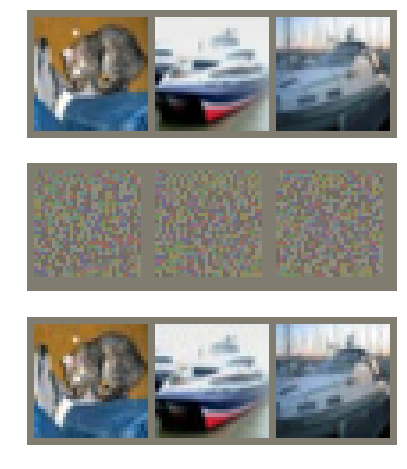

clean accuracy: 152/256 (0.59375)
dirty accuracy: 3/256 (0.01171875)
fool ratio: 197/256 (0.76953125)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1770, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


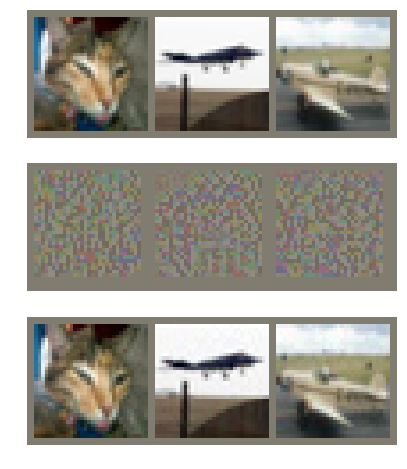

clean accuracy: 317/512 (0.619140625)
dirty accuracy: 7/512 (0.013671875)
fool ratio: 389/512 (0.759765625)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


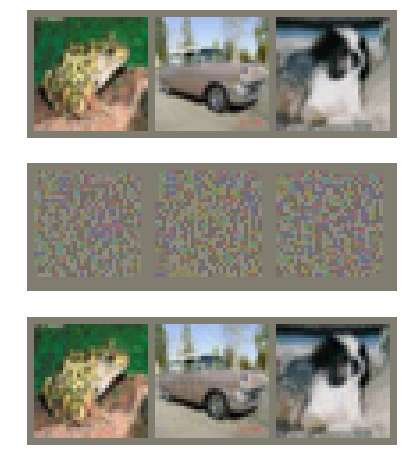

clean accuracy: 480/768 (0.625)
dirty accuracy: 8/768 (0.010416666666666666)
fool ratio: 595/768 (0.7747395833333334)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


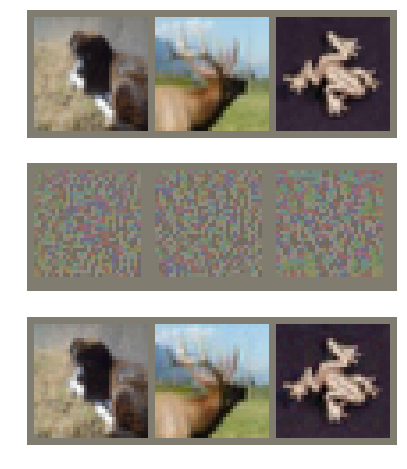

clean accuracy: 645/1024 (0.6298828125)
dirty accuracy: 11/1024 (0.0107421875)
fool ratio: 788/1024 (0.76953125)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


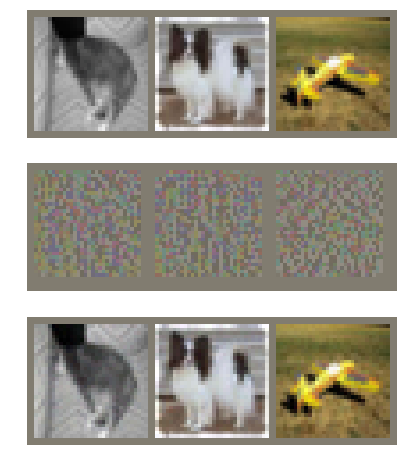

clean accuracy: 797/1280 (0.62265625)
dirty accuracy: 16/1280 (0.0125)
fool ratio: 970/1280 (0.7578125)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


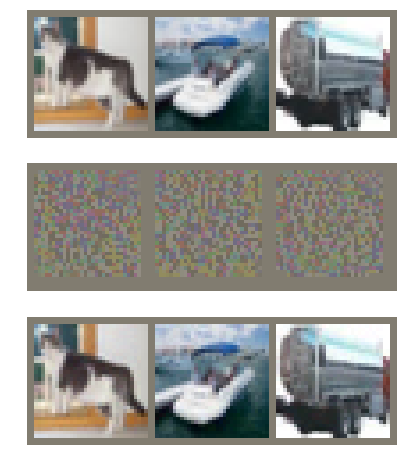

clean accuracy: 956/1536 (0.6223958333333334)
dirty accuracy: 20/1536 (0.013020833333333334)
fool ratio: 1157/1536 (0.7532552083333334)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


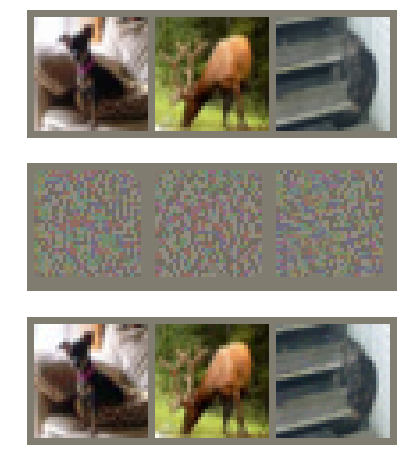

clean accuracy: 1118/1792 (0.6238839285714286)
dirty accuracy: 26/1792 (0.014508928571428572)
fool ratio: 1347/1792 (0.7516741071428571)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


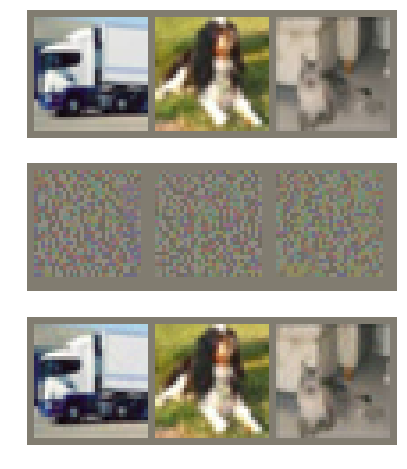

clean accuracy: 1273/2048 (0.62158203125)
dirty accuracy: 31/2048 (0.01513671875)
fool ratio: 1547/2048 (0.75537109375)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


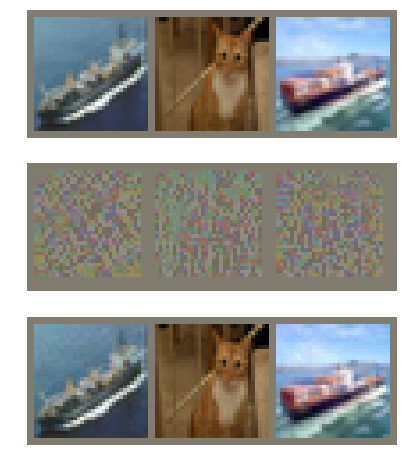

clean accuracy: 1427/2304 (0.6193576388888888)
dirty accuracy: 32/2304 (0.013888888888888888)
fool ratio: 1740/2304 (0.7552083333333334)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


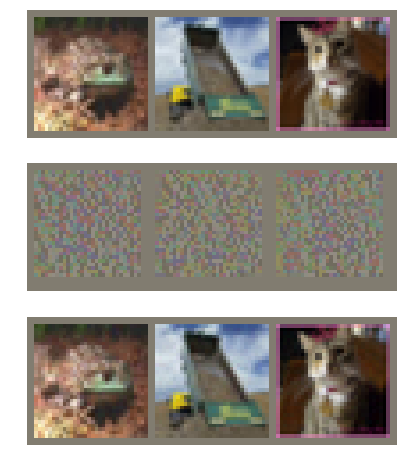

clean accuracy: 1592/2560 (0.621875)
dirty accuracy: 37/2560 (0.014453125)
fool ratio: 1931/2560 (0.754296875)
torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


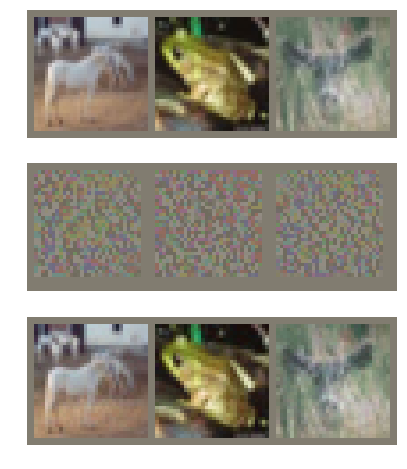

clean accuracy: 1737/2816 (0.6168323863636364)
dirty accuracy: 44/2816 (0.015625)
fool ratio: 2126/2816 (0.7549715909090909)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


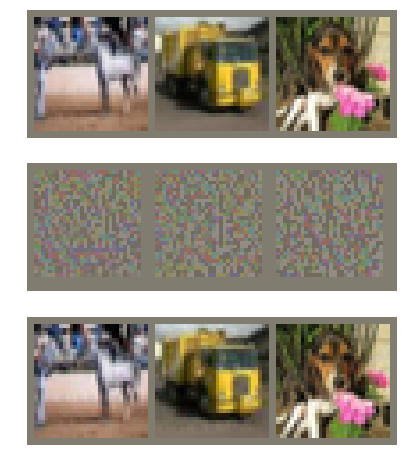

clean accuracy: 1908/3072 (0.62109375)
dirty accuracy: 46/3072 (0.014973958333333334)
fool ratio: 2338/3072 (0.7610677083333334)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


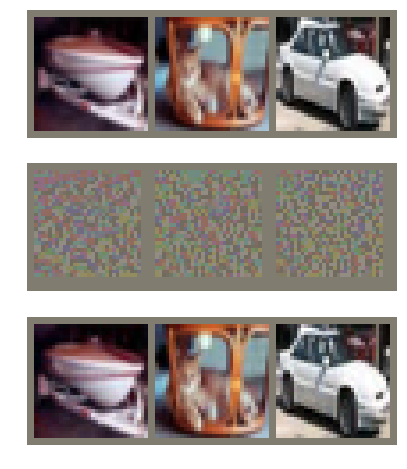

clean accuracy: 2067/3328 (0.62109375)
dirty accuracy: 54/3328 (0.01622596153846154)
fool ratio: 2527/3328 (0.7593149038461539)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


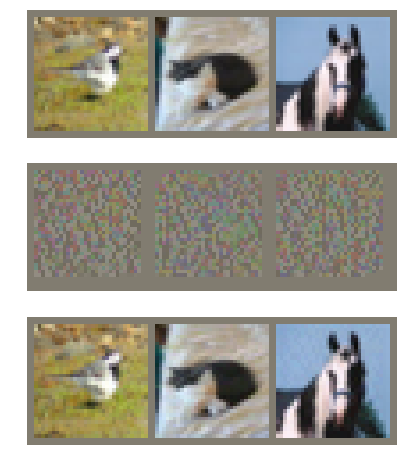

clean accuracy: 2225/3584 (0.6208147321428571)
dirty accuracy: 55/3584 (0.015345982142857142)
fool ratio: 2728/3584 (0.7611607142857143)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


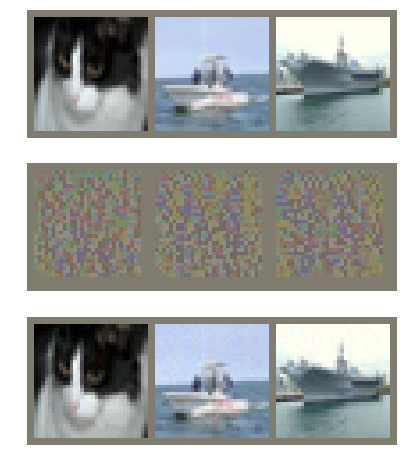

clean accuracy: 2380/3840 (0.6197916666666666)
dirty accuracy: 59/3840 (0.015364583333333333)
fool ratio: 2920/3840 (0.7604166666666666)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


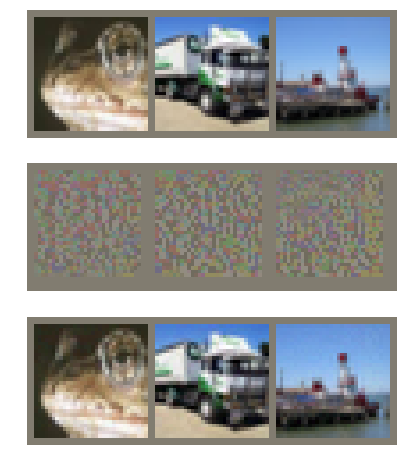

clean accuracy: 2546/4096 (0.62158203125)
dirty accuracy: 61/4096 (0.014892578125)
fool ratio: 3115/4096 (0.760498046875)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


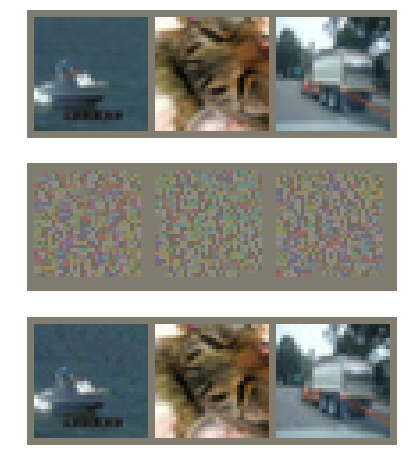

clean accuracy: 2708/4352 (0.6222426470588235)
dirty accuracy: 63/4352 (0.014476102941176471)
fool ratio: 3304/4352 (0.7591911764705882)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


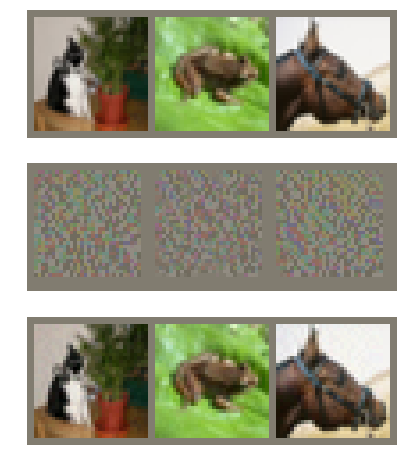

clean accuracy: 2872/4608 (0.6232638888888888)
dirty accuracy: 67/4608 (0.014539930555555556)
fool ratio: 3507/4608 (0.7610677083333334)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


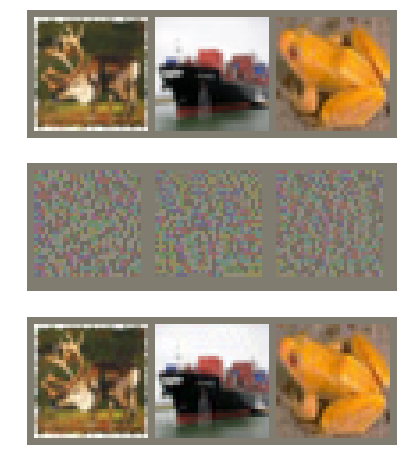

clean accuracy: 3047/4864 (0.6264391447368421)
dirty accuracy: 74/4864 (0.015213815789473685)
fool ratio: 3709/4864 (0.7625411184210527)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


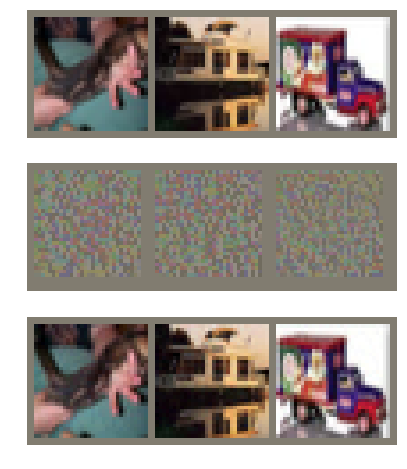

clean accuracy: 3201/5120 (0.6251953125)
dirty accuracy: 77/5120 (0.0150390625)
fool ratio: 3900/5120 (0.76171875)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


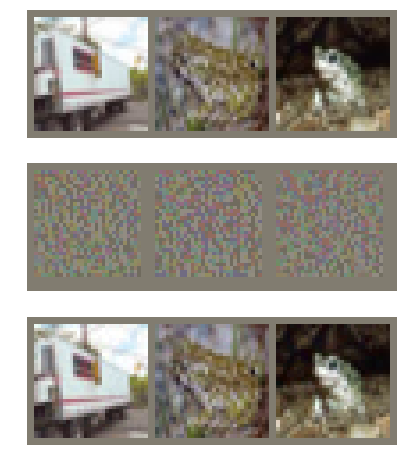

clean accuracy: 3364/5376 (0.6257440476190477)
dirty accuracy: 79/5376 (0.014694940476190476)
fool ratio: 4106/5376 (0.7637648809523809)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


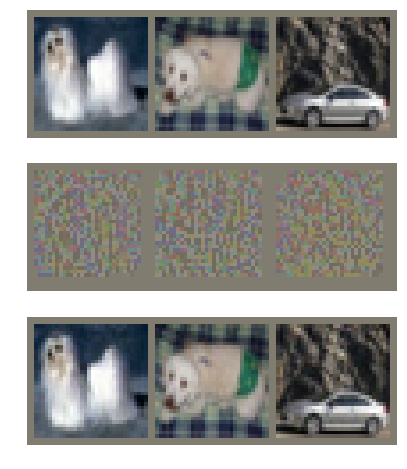

clean accuracy: 3525/5632 (0.6258877840909091)
dirty accuracy: 82/5632 (0.01455965909090909)
fool ratio: 4310/5632 (0.7652698863636364)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


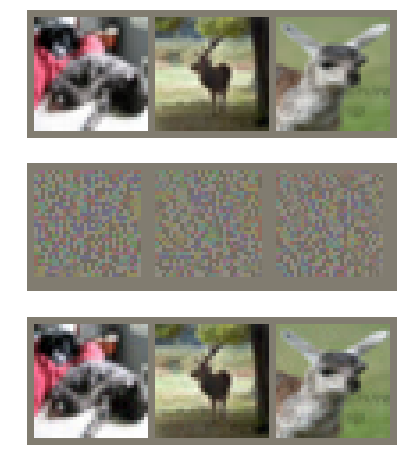

clean accuracy: 3695/5888 (0.627547554347826)
dirty accuracy: 85/5888 (0.014436141304347826)
fool ratio: 4511/5888 (0.7661345108695652)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


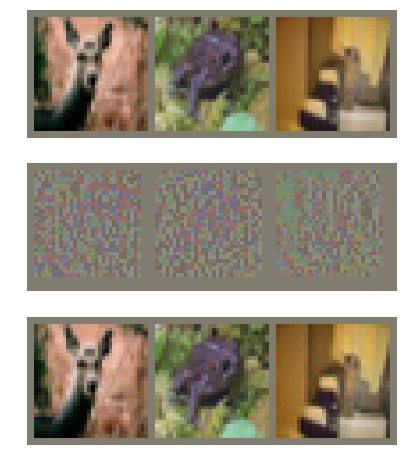

clean accuracy: 3843/6144 (0.62548828125)
dirty accuracy: 91/6144 (0.014811197916666666)
fool ratio: 4702/6144 (0.7652994791666666)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


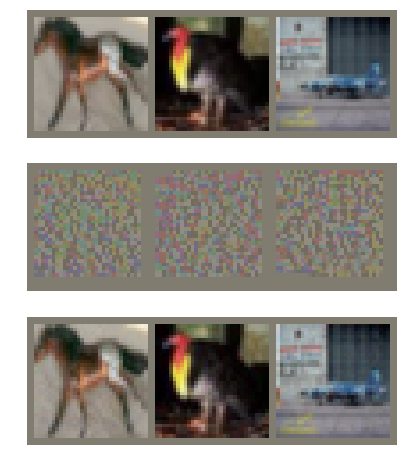

clean accuracy: 4007/6400 (0.62609375)
dirty accuracy: 98/6400 (0.0153125)
fool ratio: 4896/6400 (0.765)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


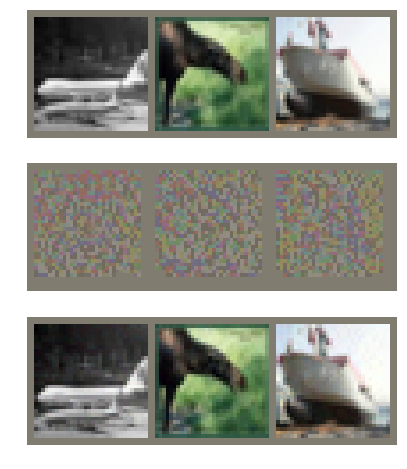

clean accuracy: 4163/6656 (0.6254507211538461)
dirty accuracy: 99/6656 (0.014873798076923076)
fool ratio: 5090/6656 (0.7647235576923077)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


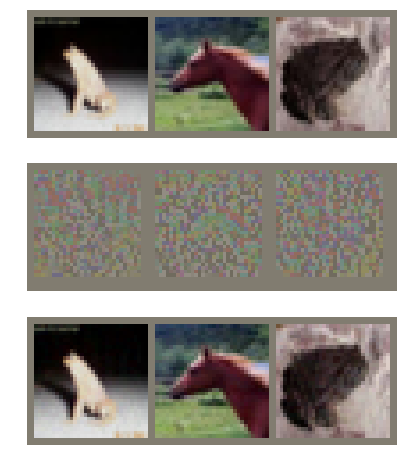

clean accuracy: 4317/6912 (0.6245659722222222)
dirty accuracy: 101/6912 (0.01461226851851852)
fool ratio: 5277/6912 (0.7634548611111112)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


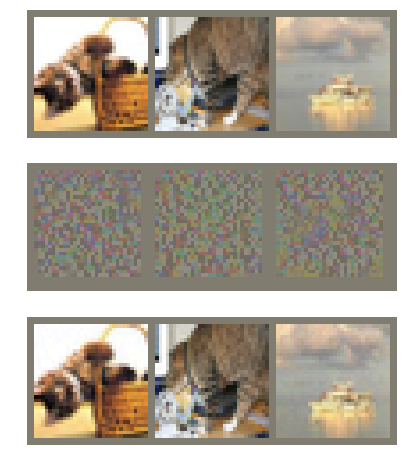

clean accuracy: 4470/7168 (0.6236049107142857)
dirty accuracy: 102/7168 (0.014229910714285714)
fool ratio: 5469/7168 (0.7629743303571429)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


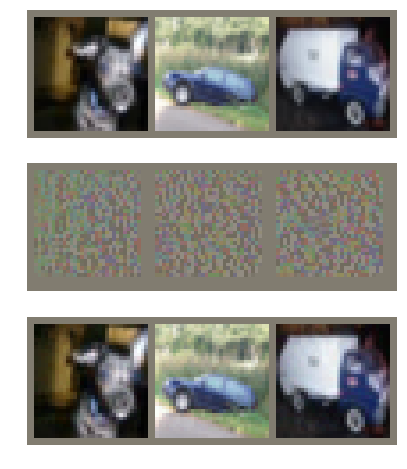

clean accuracy: 4646/7424 (0.6258081896551724)
dirty accuracy: 103/7424 (0.013873922413793104)
fool ratio: 5679/7424 (0.7649515086206896)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


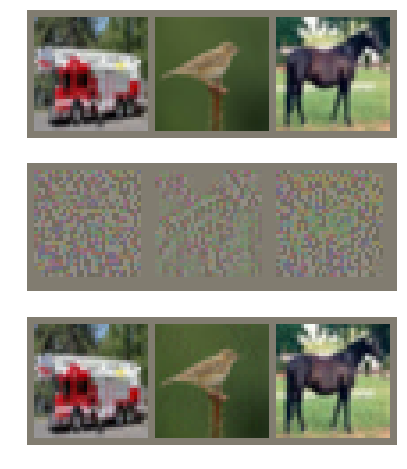

clean accuracy: 4800/7680 (0.625)
dirty accuracy: 106/7680 (0.013802083333333333)
fool ratio: 5868/7680 (0.7640625)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1769, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


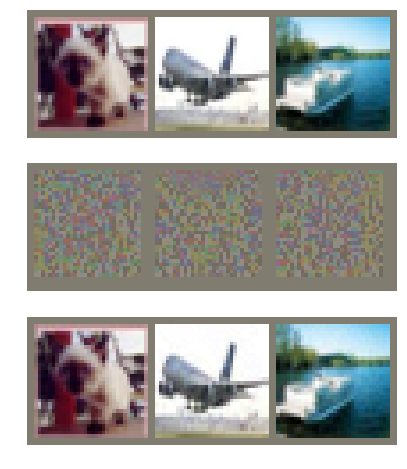

clean accuracy: 4955/7936 (0.6243699596774194)
dirty accuracy: 113/7936 (0.01423891129032258)
fool ratio: 6055/7936 (0.7629788306451613)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1769, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


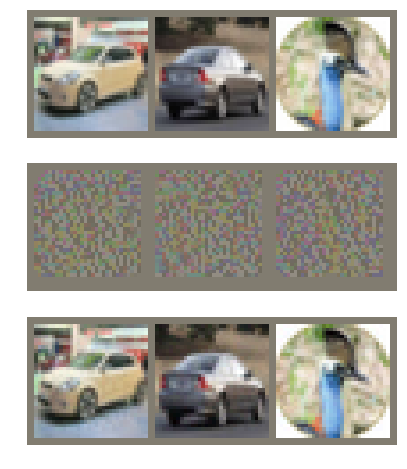

clean accuracy: 5129/8192 (0.6260986328125)
dirty accuracy: 119/8192 (0.0145263671875)
fool ratio: 6258/8192 (0.763916015625)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


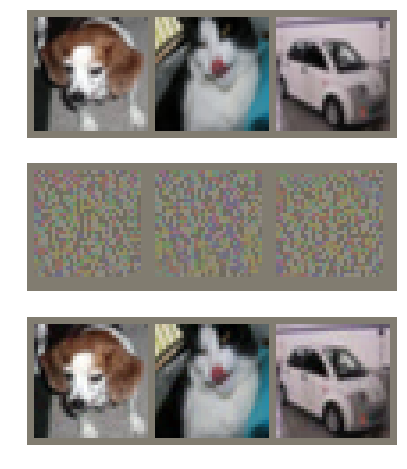

clean accuracy: 5278/8448 (0.6247632575757576)
dirty accuracy: 121/8448 (0.014322916666666666)
fool ratio: 6443/8448 (0.7626657196969697)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


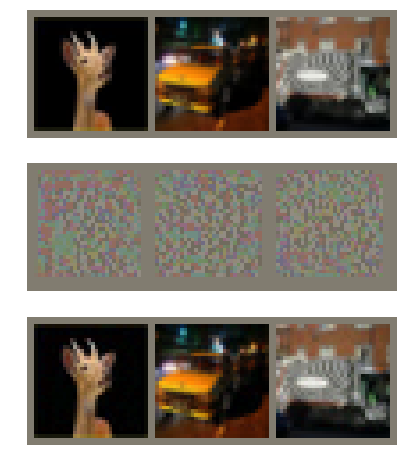

clean accuracy: 5430/8704 (0.6238511029411765)
dirty accuracy: 121/8704 (0.013901654411764705)
fool ratio: 6634/8704 (0.7621783088235294)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


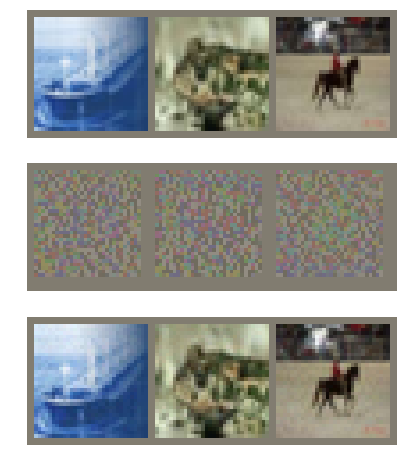

clean accuracy: 5594/8960 (0.6243303571428571)
dirty accuracy: 123/8960 (0.013727678571428571)
fool ratio: 6834/8960 (0.7627232142857143)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


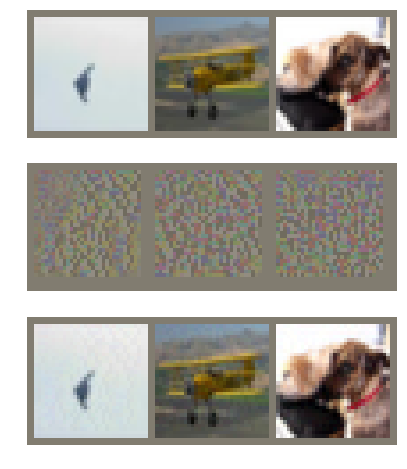

clean accuracy: 5766/9216 (0.6256510416666666)
dirty accuracy: 126/9216 (0.013671875)
fool ratio: 7034/9216 (0.7632378472222222)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


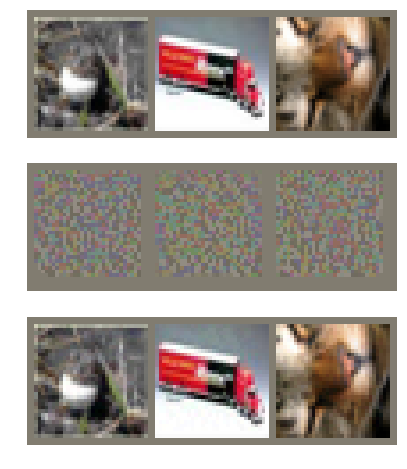

clean accuracy: 5910/9472 (0.6239442567567568)
dirty accuracy: 131/9472 (0.013830236486486486)
fool ratio: 7231/9472 (0.7634079391891891)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


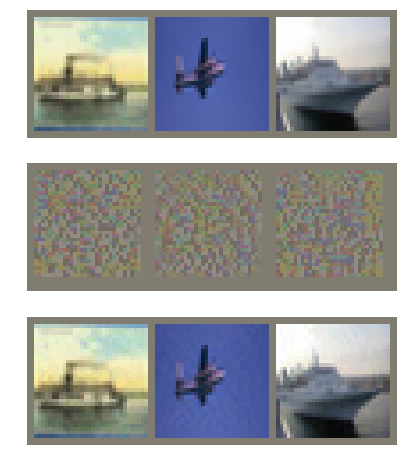

clean accuracy: 6071/9728 (0.6240748355263158)
dirty accuracy: 139/9728 (0.014288651315789474)
fool ratio: 7422/9728 (0.762952302631579)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 256])
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


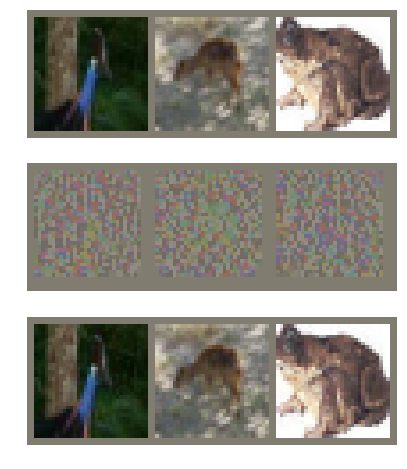

clean accuracy: 6220/9984 (0.6229967948717948)
dirty accuracy: 141/9984 (0.014122596153846154)
fool ratio: 7609/9984 (0.7621193910256411)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([132, 16])
tensor(0.1774, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<MaxBackward1>)


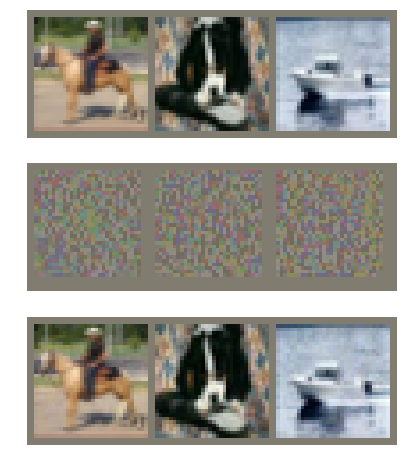

clean accuracy: 6228/10000 (0.6228)
dirty accuracy: 141/10000 (0.0141)
fool ratio: 7619/10000 (0.7619)


In [117]:
EPS=0.05
NUM_ITERS=10
fcorrect = 0
ccorrect = 0
dcorrect = 0
total = 0
iters = 0
for data, target in test_loader:
    model.eval()
    likelihood.eval()

    data, target = data.cuda(), target.cuda()
    res = ifgsm(model, data, target, niters=NUM_ITERS, epsilon=EPS, learning_rate=EPS*2/NUM_ITERS)
#     print(data.abs().max(), res.abs().max())
    out = likelihood(model(res))
    cout = likelihood(model(data))
    print(model(res).variance.shape)
    print(avg(avg(model(res).variance)))
    print(avg(avg(model(data).variance)))
#     break
#     print(out)
    visualize_adv(data, res-data, res)
    pred = out.probs.argmax(1)
    cpred = cout.probs.argmax(1)
    fcorrect += pred.eq(cpred).cpu().sum()
    ccorrect += cpred.eq(target).cpu().sum()
    dcorrect += pred.eq(target).cpu().sum()
#     correct += pred.eq(target.view_as(pred)).cpu().sum()

    total += data.size()[0]
    
#     print(out)
#     print(out.probs[0].max(), out.probs[0].argmax(), target[0])
#     with torch.no_grad():
#         output = likelihood(model(data))
#         pred = output.probs.argmax(1)
#         correct += pred.eq(target.view_as(pred)).cpu().sum()
    
    print('clean accuracy: {}/{} ({})'.format(
        ccorrect, total, float(ccorrect) / float(total)
    ))
    print('dirty accuracy: {}/{} ({})'.format(
        dcorrect, total, float(dcorrect) / float(total)
    ))
    print('fool ratio: {}/{} ({})'.format(
        total - fcorrect, total, float(total - fcorrect) / float(total)
    ))
    iters += 1
    
#     if iters >2:
#         break